Tasks (05/11/24)

1. [x] Complete handling of Null Values
2. [x] Complete handling of Erroneous Values
3. [x] Complete handling of Duplicate Values

Tasks (11/11/24)

1. [x] Complete Univariate Analysis of Categorical Variables
2. [x] Complete Univariate Analysis of Numerical Variables
3. [ ] Complete Multivariate Analsis of Variables with Target

Tasks (12/11/24)

1. [ ] Perform a test-train split from the start


In [2]:
#Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Inspection and Ingestion

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

datasets = [df_train, df_test]

for df in datasets:
    
    df.set_index("id", inplace=True)

In [4]:
df_train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


*Comments*

Looks like "working professional or student" is a binary indicator, profession looks like a high cardinality, null may indicate unemployed, though we should bare in mind the previous binary column, we can see some columns only apply to students and others to workers, perhaps these can be combined into a single column. sleep duration and dietary habits are ordinal. will need to intepret city somehow, perhaps we can get the gdp of the city or the location of the city, it is synthetic data so perhaps it does not pick this up. May also need to interpret degree.

*Hypotheses*

1. suicidal thoughts will correlate highly with depression.
2. financial stress will correlate highly with depression.
3. financial stress will depend on whether someone is employed.
4. students will be more susceptible to depression.
5. young people will be more susceptible to depression than old people.
6. age will correlate with student.
7. lack of sleep will correlate heavily with depression.



In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  

*Comments*

We have 18 feature columns and 1 target column "Depression" over 140,000 observations. We have null values in "Profession" (likely only applies to workers), "Academic Pressure" (likely only applies to students), "Work Pressure" (likely only applies to workers), "CGPA" and "Study Satisfaction" (likely only applies to students), "Job Satisfaction" again likely only applies to workers, we can see also some small count of null values in financial stress and degree, dietary habits, these can likely be imputed or even dropped as so small. If age is rounded to year can just be an integer.

<Axes: >

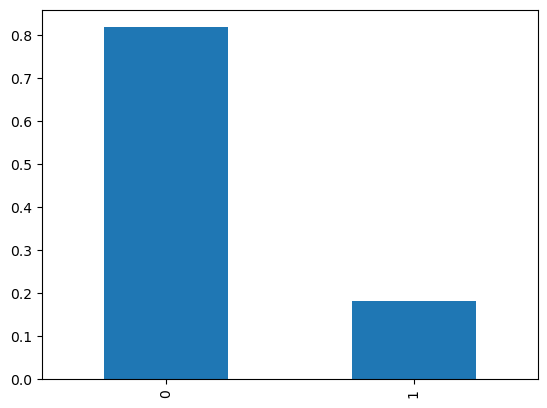

In [6]:
df_train["Depression"].value_counts(normalize=True).plot(kind="bar")

# Handling Missing Data

<Axes: xlabel='id'>

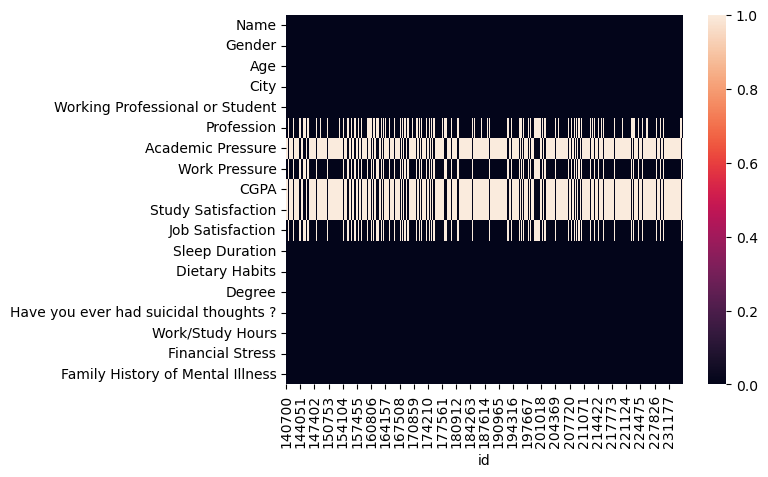

In [7]:
sns.heatmap(df.isna().T)

In [8]:
df_train.isna().sum().T

Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [9]:
#impute using mode to handle these null values
for df in datasets:
    for column in ["Dietary Habits", "Degree", "Financial Stress"]:
        df[column].fillna(df[column].mode()[0], inplace=True)

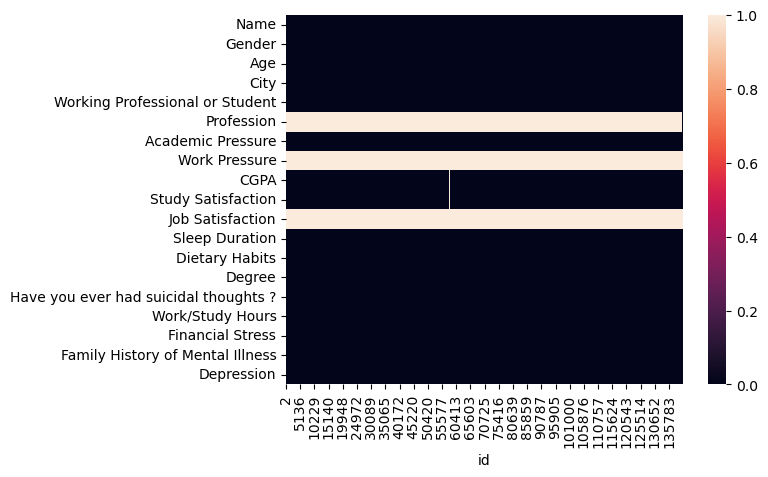

In [10]:
sns.heatmap(df_train[df_train["Working Professional or Student"]=="Student"].isna().T)
plt.show()

In [11]:
df_train[df_train["Working Professional or Student"]=="Student"].isna().sum()

Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               27867
Academic Pressure                            9
Work Pressure                            27898
CGPA                                         9
Study Satisfaction                          10
Job Satisfaction                         27893
Sleep Duration                               0
Dietary Habits                               0
Degree                                       0
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
Depression                                   0
dtype: int64

In [12]:
for df in datasets:
    for column in ["Academic Pressure", "CGPA", "Study Satisfaction"]:
        df.loc[(df["Working Professional or Student"]=="Student")&(df[column].isna()),column] = df[column].mode()[0]

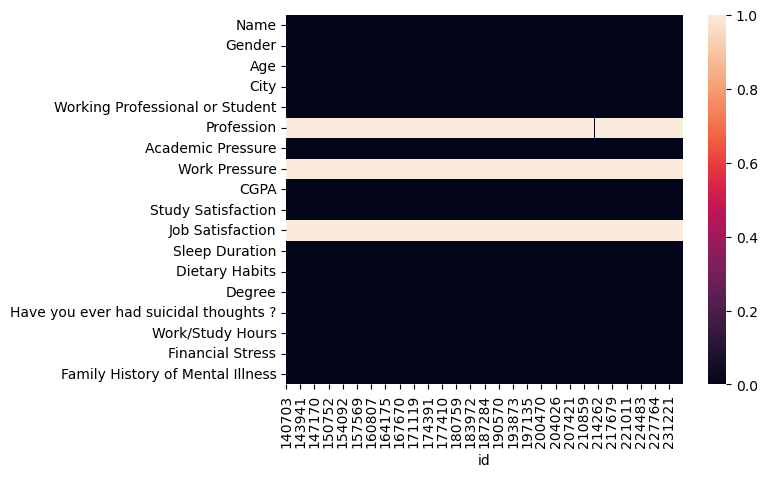

In [13]:
sns.heatmap(df[df["Working Professional or Student"]=="Student"].isna().T)
plt.show()

*Comments*

Now, let's check out our working professional case.

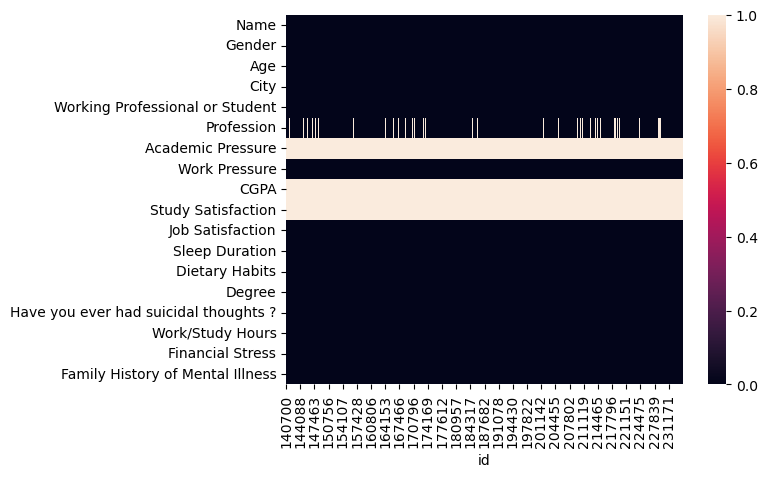

In [14]:
sns.heatmap(df[df["Working Professional or Student"]=="Working Professional"].isna().T)
plt.show()

In [15]:
df[df["Working Professional or Student"]=="Working Professional"].isna().sum()

Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                                5886
Academic Pressure                        75026
Work Pressure                               10
CGPA                                     75025
Study Satisfaction                       75025
Job Satisfaction                             9
Sleep Duration                               0
Dietary Habits                               0
Degree                                       0
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
dtype: int64

In [16]:
for df in datasets:
    for column in ["Work Pressure", "Job Satisfaction"]:
        df.loc[(df["Working Professional or Student"]=="Working Professional")&(df[column].isna()),column] = df[column].mode()[0]

In [17]:
#compute the mean for the group
df_train[df_train["Working Professional or Student"]=="Working Professional"].groupby(df_train["Profession"].isna())["Depression"].agg({"count","mean"})

,mean,count
Profession,,
False,0.057134,104036
True,0.375100,8763


In [18]:
import scipy.stats as stats
import numpy as np

# Define observed frequencies based on given data
# Group A: Na_Profession = False
count_a = 104036
proportion_a = 0.057134
success_a = int(count_a * proportion_a)
failure_a = count_a - success_a

# Group B: Na_Profession = True
count_b = 8763
proportion_b = 0.375100
success_b = int(count_b * proportion_b)
failure_b = count_b - success_b

# Create a 2x2 contingency table
observed = np.array([[success_a, failure_a], [success_b, failure_b]])

# Perform the chi-squared test
chi2, p_value, _, _ = stats.chi2_contingency(observed)

p_value


0.0

*Comments*

We can see that there is large difference in prevelance of depression in our two cohorts, in the case of a working professional lending weight to the hypothesis that this is down to them being unemployed rather than an entry error.

In [19]:
#impute null values with unemployed
for df in datasets:
    df.loc[(df["Working Professional or Student"]=="Working Professional") & (df["Profession"].isna()),"Profession"] = "Unemployed"

In [20]:
df.isna().sum()

Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               18746
Academic Pressure                        75026
Work Pressure                            18768
CGPA                                     75025
Study Satisfaction                       75025
Job Satisfaction                         18765
Sleep Duration                               0
Dietary Habits                               0
Degree                                       0
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
dtype: int64

In [21]:
#We can combine student column with profession column

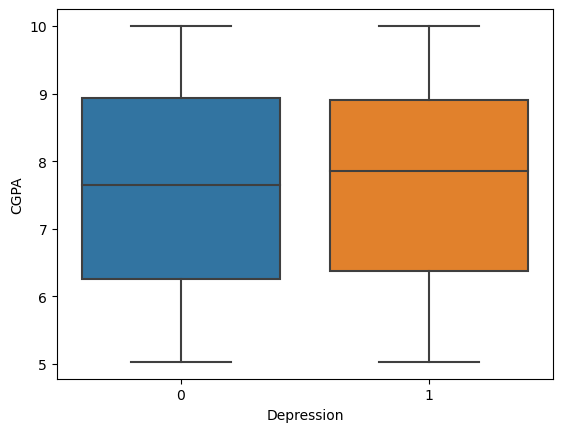

In [22]:
#We can drop CGPA becuase it complicates the workflow and does not inform on Depression
sns.boxplot(data=df_train, y="CGPA", x="Depression")

for df in datasets:
    df.drop(columns="CGPA", inplace=True)

In [23]:
for df in datasets:
    df["Work/Academic Pressure"] = df["Academic Pressure"].where(~df["Academic Pressure"].isna(), 0) + df["Work Pressure"].where(~df["Work Pressure"].isna(), 0)

In [24]:
for df in datasets:
    df.drop(columns=["Work Pressure", "Academic Pressure"], inplace=True)

In [25]:
for df in datasets:
    df["Study/Job Satisfaction"] = df["Study Satisfaction"].where(~df["Study Satisfaction"].isna(), 0) +df["Job Satisfaction"].where(~df["Job Satisfaction"].isna(), 0)

In [26]:
for df in datasets:
    df.drop(columns=["Study Satisfaction", "Job Satisfaction"], inplace=True)

In [27]:
for df in datasets:
    df["Profession"] = df["Profession"].where(~df["Profession"].isna(),"Student")

# Handle Erroneous Values

In this section we handle

In [29]:
[column for column in df.columns.where(df.dtypes=="object")]

['Name',
 'Gender',
 None,
 'City',
 'Working Professional or Student',
 'Profession',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 None,
 None,
 'Family History of Mental Illness',
 None,
 None]

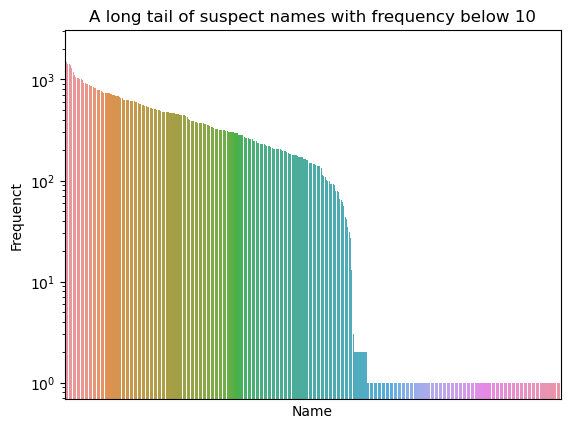

In [30]:
#Count the occurrences and sort by frequency
ordered_counts = df['Name'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values)

#Add labels and title
plt.xlabel('Name')
plt.ylabel('Frequenct')
plt.title('A long tail of suspect names with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

*Comments*

We can see that in this log scale the Name variable has a long tail of single instances indicative of entry errors.

In [31]:
pd.set_option('display.max_rows', None)

#We can see the tail is contaminated by entry errors, so we can cut it given the low count in the tail.
ordered_counts[ordered_counts.values < 10]

Anishwarya            3
Rupar                 2
Shivan                2
Rya                   2
BE                    2
Surat                 2
Aarohan               2
Anarav                2
Aarsha                2
Shashi                2
Kolkata               2
Harshit               1
Aneshv                1
Shvi                  1
Nikhaan               1
Ashita                1
Ishin                 1
Ranvi                 1
Bhauri                1
Vai                   1
Anariv                1
Pr.Ed                 1
Chibha                1
Ritita                1
Aalalav               1
Tohar                 1
Tanveer               1
Parvi                 1
Tanvik                1
Vashi                 1
Anakash               1
Vaaya                 1
MCA                   1
Kishti                1
Aradhya               1
Anita                 1
Krishna/ Krishna      1
Yashi                 1
Pranch                1
Vidara                1
R. Bhavna             1
Shir            

In [32]:
ordered_counts[ordered_counts.values < 10].values.sum()

169

*Comment*

Given the low count in the tail we can cut it off and drop these contaminated rows.

In [33]:
# Precompute the index of values < 10
names_to_exclude = ordered_counts[ordered_counts.values < 10].index

# Now use the precomputed result in the isin()
df = df[~df["Name"].isin(names_to_exclude)]

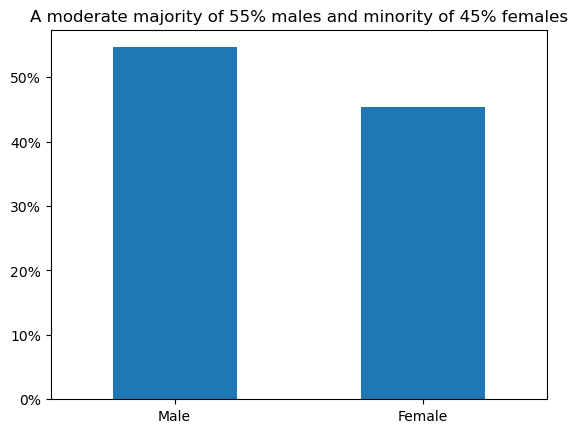

In [34]:
gender_split = df["Gender"].value_counts(normalize=True)

plt.figure()
gender_split.plot(kind="bar")
plt.title(f"A moderate majority of {int(round(gender_split['Male']*100,0))}% males and minority of {int(round(gender_split['Female']*100,0))}% females")
plt.xticks(rotation=0)
plt.yticks(labels=[f"{number}%" for number in np.arange(0,60,10)], ticks=np.arange(0,0.6,0.1))

plt.show()

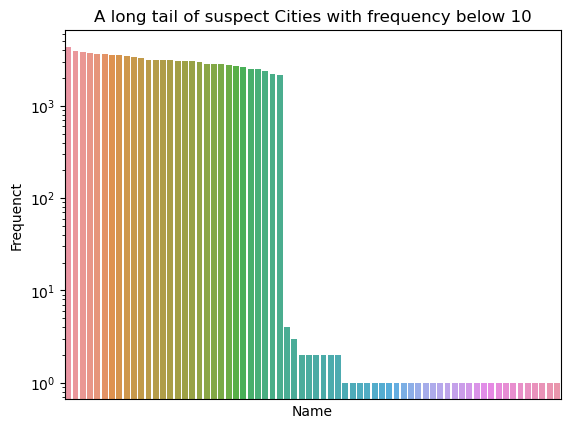

In [35]:
#Count the occurrences and sort by frequency
ordered_counts = df['City'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values)

#Add labels and title
plt.xlabel('Name')
plt.ylabel('Frequenct')
plt.title('A long tail of suspect Cities with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [36]:
ordered_counts[ordered_counts.values < 10]

Vidya                4
Siddhesh             3
Bhavna               2
Hrithik              2
City                 2
Nalini               2
Keshav               2
Vikram               2
Malyan               1
Pratyush             1
Less than 5 hours    1
Mhopal               1
Avni                 1
Ira                  1
Vaishnavi            1
Lawyer               1
Thani                1
Unaly                1
Is Kanpur            1
Golkata              1
Less Delhi           1
Sara                 1
Saurav               1
Aditi                1
Parth                1
Rolkata              1
Abhinav              1
Vidhi                1
Pratham              1
Saanvi               1
More Delhi           1
No                   1
Ghopal               1
Chemist              1
Leela                1
Vaikot               1
San Vasai-Virar      1
No.12                1
Name: City, dtype: int64

*Comment*

Again we see a contaminated tail which can be dropped on grounds of it being low in count.

In [37]:
ordered_counts[ordered_counts.values < 10].sum()

49

In [38]:
# Precompute the index of values < 10
names_to_exclude = ordered_counts[ordered_counts.values < 10].index

# Now use the precomputed result in the isin()
df = df[~df["City"].isin(names_to_exclude)]

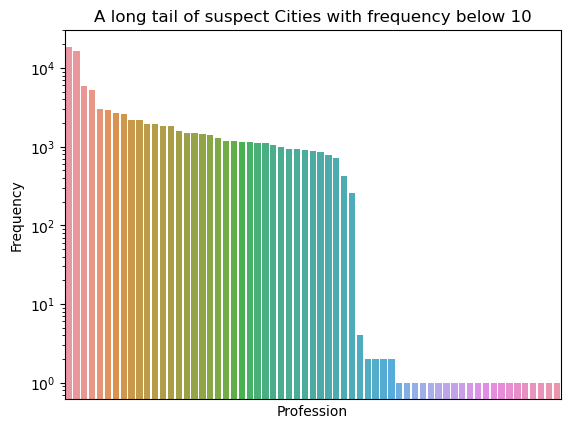

In [39]:
#Count the occurrences and sort by frequency
ordered_counts = df['Profession'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values)

#Add labels and title
plt.xlabel('Profession')
plt.ylabel('Frequency')
plt.title('A long tail of suspect Cities with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [40]:
ordered_counts[ordered_counts.values < 10]

Working Professional    4
MD                      2
Surat                   2
B.Ed                    2
Unhealthy               2
Yogesh                  1
M.Ed                    1
PhD                     1
Samar                   1
3M                      1
Manvi                   1
B.Pharm                 1
ME                      1
24th                    1
Name                    1
BBA                     1
Simran                  1
Analyst                 1
Profession              1
MCA                     1
M.Tech                  1
Surgeon                 1
City Consultant         1
No                      1
Unveil                  1
M.Pharm                 1
Name: Profession, dtype: int64

In [41]:
ordered_counts[ordered_counts.values < 10].sum()

33

In [42]:
# Precompute the index of values < 10
names_to_exclude = ordered_counts[ordered_counts.values < 10].index

# Now use the precomputed result in the isin()
df = df[~df["Profession"].isin(names_to_exclude)]

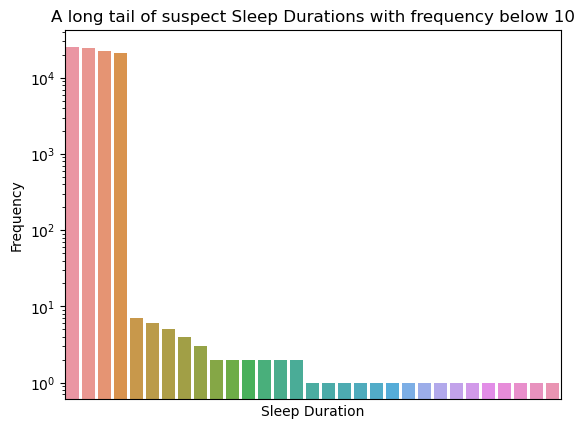

In [43]:
#Count the occurrences and sort by frequency
ordered_counts = df['Sleep Duration'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values)

#Add labels and title
plt.xlabel('Sleep Duration')
plt.ylabel('Frequency')
plt.title('A long tail of suspect Sleep Durations with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [44]:
ordered_counts[ordered_counts.values < 15].sum()

53

In [45]:
# Precompute the index of values < 15
names_to_exclude = ordered_counts[ordered_counts.values < 15].index

# Now use the precomputed result in the isin()
df = df[~df["Sleep Duration"].isin(names_to_exclude)]

In [46]:
df.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness',
       'Work/Academic Pressure', 'Study/Job Satisfaction'],
      dtype='object')

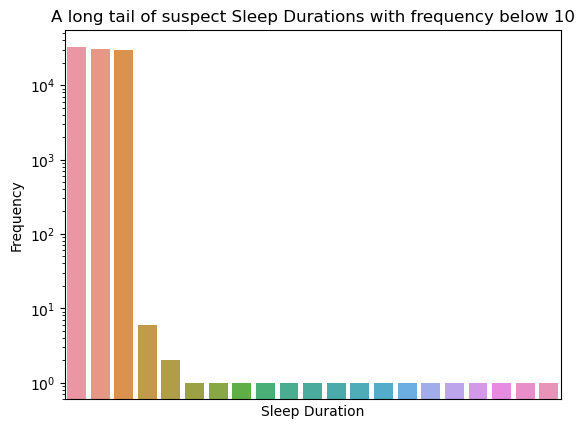

In [47]:
#Count the occurrences and sort by frequency
ordered_counts = df['Dietary Habits'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values)

#Add labels and title
plt.xlabel('Sleep Duration')
plt.ylabel('Frequency')
plt.title('A long tail of suspect Sleep Durations with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [48]:
ordered_counts[ordered_counts.values < 10].sum()

24

In [49]:
# Precompute the index of values < 15
names_to_exclude = ordered_counts[ordered_counts.values < 10].index

# Now use the precomputed result in the isin()
df = df[~df["Dietary Habits"].isin(names_to_exclude)]

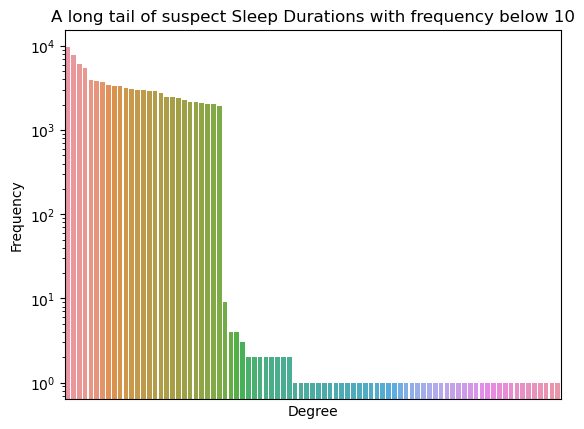

In [50]:
#Count the occurrences and sort by frequency
ordered_counts = df['Degree'].value_counts().sort_values(ascending=False)

#Create the ordered count plot
sns.barplot(x=ordered_counts.index, y=ordered_counts.values)

#Add labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('A long tail of suspect Sleep Durations with frequency below 10')
plt.yscale('log')
plt.xticks(ticks=[])
plt.show()

In [51]:
ordered_counts[ordered_counts.values < 10].sum()

82

In [52]:
# Precompute the index of values < 15
names_to_exclude = ordered_counts[ordered_counts.values < 10].index

# Now use the precomputed result in the isin()
df = df[~df["Degree"].isin(names_to_exclude)]

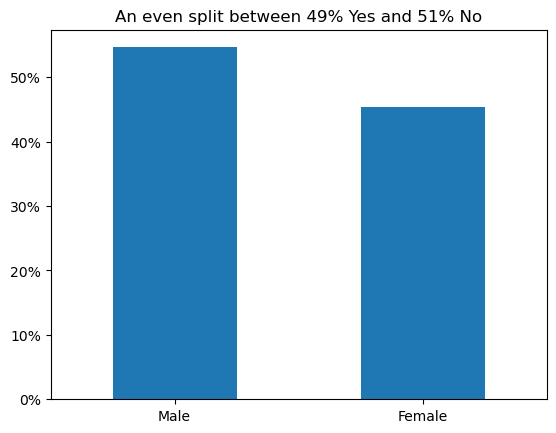

In [53]:
suicidal_split = df['Have you ever had suicidal thoughts ?'].value_counts(normalize=True)

plt.figure()
gender_split.plot(kind="bar")
plt.title(f"An even split between {int(round(suicidal_split['Yes']*100,0))}% Yes and {int(round(suicidal_split['No']*100,0))}% No")
plt.xticks(rotation=0)
plt.yticks(labels=[f"{number}%" for number in np.arange(0,60,10)], ticks=np.arange(0,0.6,0.1))

plt.show()

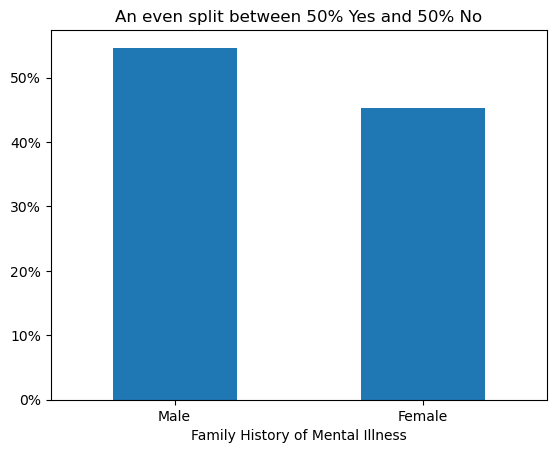

In [54]:
suicidal_split = df['Family History of Mental Illness'].value_counts(normalize=True)

plt.figure()
gender_split.plot(kind="bar")
plt.title(f"An even split between {int(round(suicidal_split['Yes']*100,0))}% Yes and {int(round(suicidal_split['No']*100,0))}% No")
plt.xticks(rotation=0)
plt.yticks(labels=[f"{number}%" for number in np.arange(0,60,10)], ticks=np.arange(0,0.6,0.1))
plt.xlabel('Family History of Mental Illness')

plt.show()

Now we can examine the numerical values

In [55]:
df.describe(include="number")

,Age,Work/Study Hours,Financial Stress,Work/Academic Pressure,Study/Job Satisfaction
count,93390.000000,93390.000000,93390.000000,93390.000000,93390.000000
mean,40.325132,6.247468,2.978692,3.041300,2.957008
std,12.393790,3.858950,1.414530,1.401717,1.403949
min,18.000000,0.000000,1.000000,1.000000,1.000000
25%,29.000000,3.000000,2.000000,2.000000,2.000000
50%,42.000000,6.000000,3.000000,3.000000,3.000000
75%,51.000000,10.000000,4.000000,4.000000,4.000000
max,60.000000,12.000000,5.000000,8.000000,9.000000


In [56]:
#There are no obviously numerical values

In [57]:
df.shape[0]/140700*100 #We retain the vast majority of cases from this.

66.37526652452026

# Handle Duplicate Values

In [58]:
#We can see there are no duplicated values.
df.duplicated().sum()

0

#Univariate Analysis

<Axes: >

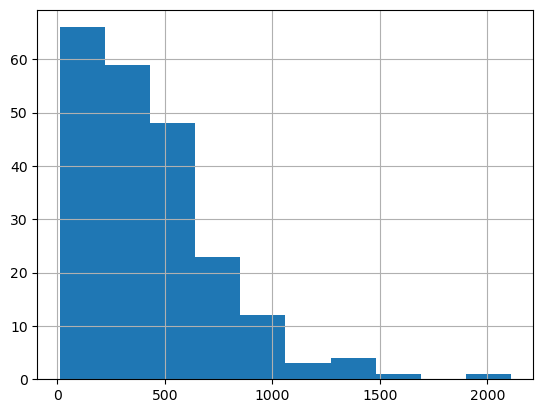

In [59]:
df["Name"].value_counts().hist()

In [60]:
df["Name"].value_counts().head(10)

Rohan          2109
Aarav          1499
Rupak          1431
Aaradhya       1421
Anvi           1395
Raghavendra    1303
Tushar         1168
Vani           1096
Rashi          1062
Ritvik         1032
Name: Name, dtype: int64

*Comments*

first name is heavily skewed with a minority of names accounting for the majority. It is not clear what information name can provide, perhaps it can indicate social status e.g. caste or region but these factors can be adequately captured by the other vairables so we can drop this column.

In [61]:
df.drop(columns="Name", inplace=True)

<Axes: ylabel='Frequency'>

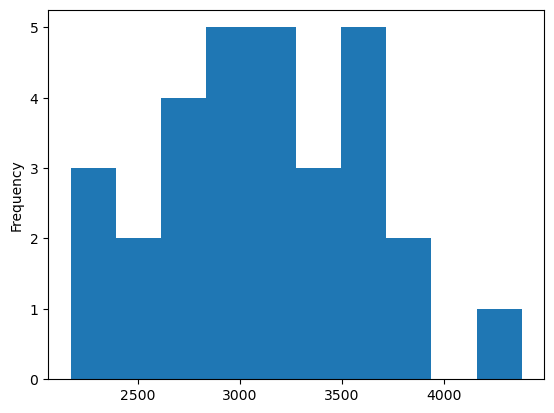

In [62]:
df["City"].value_counts().sort_values(ascending=True).plot(kind="hist")

<Axes: >

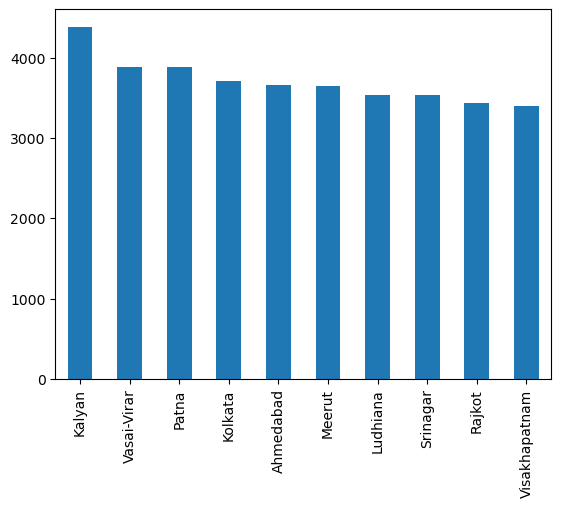

In [63]:
df["City"].value_counts()[:10].plot(kind="bar")

In [64]:
df["City"].value_counts().describe()

count      30.000000
mean     3113.000000
std       529.749778
min      2169.000000
25%      2760.250000
50%      3092.000000
75%      3506.500000
max      4380.000000
Name: City, dtype: float64

In [65]:
df["City"].describe()

count      93390
unique        30
top       Kalyan
freq        4380
Name: City, dtype: object

*Comments*

Frequencies of cities range between 3000 and 6000, looks symettric.

<Axes: >

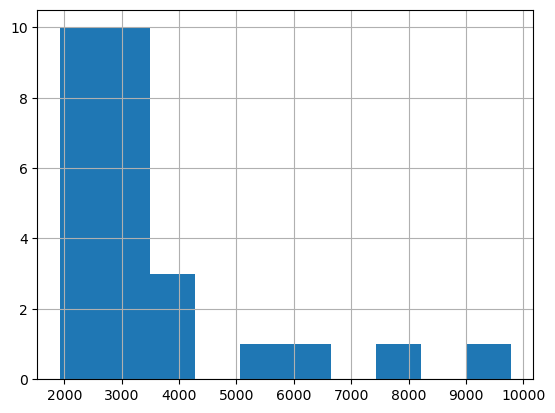

In [66]:
df["Degree"].value_counts().hist()

In [67]:
df["Degree"].describe()

count        93390
unique          27
top       Class 12
freq          9784
Name: Degree, dtype: object

In [68]:
df["Degree"].value_counts().describe()

count      27.000000
mean     3458.888889
std      1832.495909
min      1925.000000
25%      2328.000000
50%      2986.000000
75%      3562.000000
max      9784.000000
Name: Degree, dtype: float64

*Comment*

We can see that degree is right skewed in frequency, with class 12 dominating. We may need to group all uninformative degree labels in other.

<Axes: >

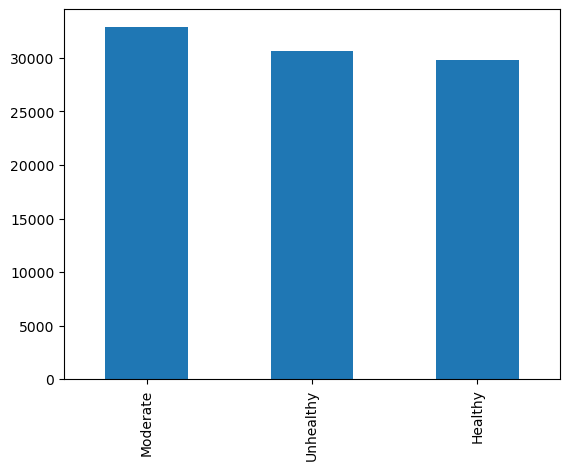

In [69]:
df["Dietary Habits"].value_counts().plot(kind="bar") #uniform distrubutuib

<Axes: ylabel='Frequency'>

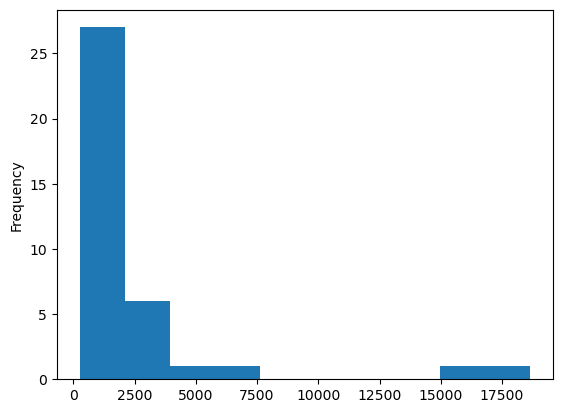

In [70]:
df["Profession"].value_counts().plot(kind="hist")

In [71]:
#We can see a strong right skew in frequency, dominated by a few professions.

In [72]:
df.columns

Index(['Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness',
       'Work/Academic Pressure', 'Study/Job Satisfaction'],
      dtype='object')

<Axes: >

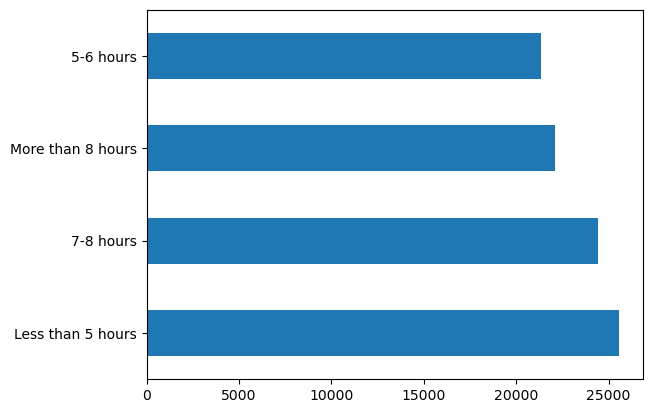

In [73]:
df["Sleep Duration"].value_counts().plot(kind="barh")

*Comments*

roughly uniform with four unique values, less than 5 hours most common.

<Axes: >

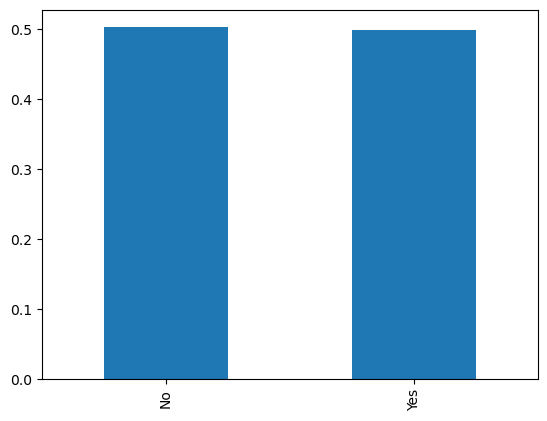

In [74]:
df["Family History of Mental Illness"].value_counts(normalize=True).plot(kind="bar")

<Axes: >

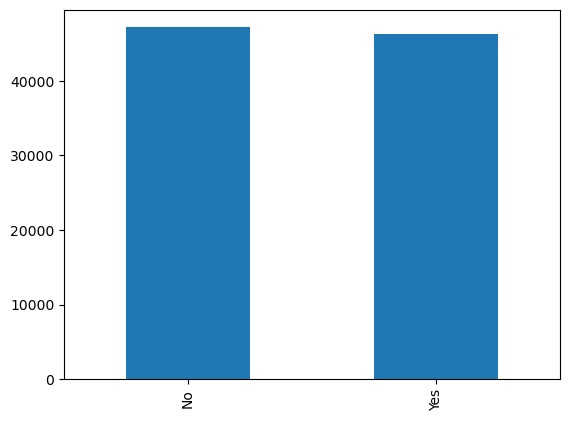

In [75]:
df["Have you ever had suicidal thoughts ?"].value_counts().plot(kind="bar")

In [76]:
df["Depression"].value_counts(normalize=True).plot(kind="bar")

KeyError: 'Depression'

*Comment*

We can see a class imbalance in our target column of roughly 6 to 1, which may require handling during the training process.

In [ ]:
df["Age"].describe()

count    140067.000000
mean         40.392634
std          12.383236
min          18.000000
25%          29.000000
50%          42.000000
75%          51.000000
max          60.000000
Name: Age, dtype: float64

<Axes: >

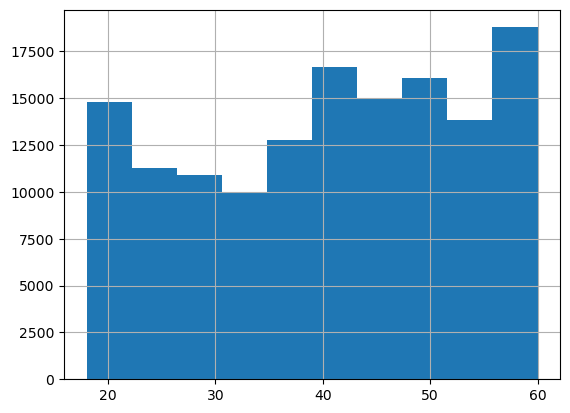

In [ ]:
df["Age"].hist()

*Comments*

Clearly only adults from 18 to 60 have been asked, looks roughly uniform.

<Axes: ylabel='Frequency'>

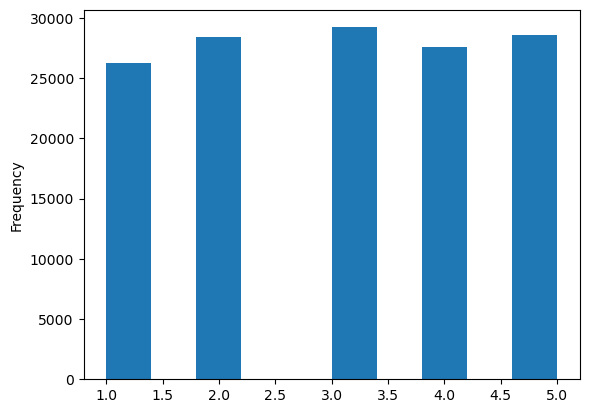

In [ ]:
df['Work/Academic Pressure'].plot(kind="hist")

<Axes: ylabel='Frequency'>

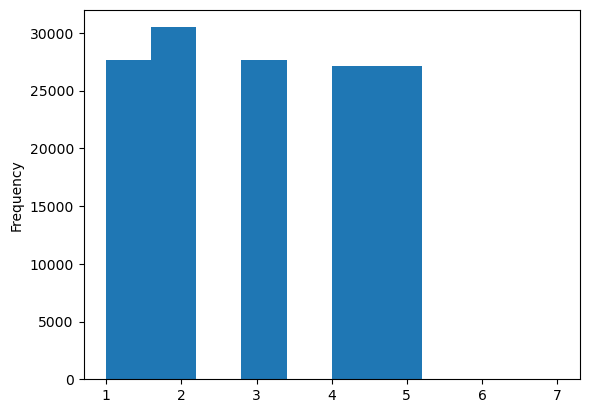

In [ ]:
df['Study/Job Satisfaction'].plot(kind="hist")

In [ ]:
df["Financial Stress"].describe()

count    140067.000000
mean          2.989012
std           1.413461
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: Financial Stress, dtype: float64

In [ ]:
# Bivariate Analysis

In [ ]:
pd.crosstab(df['Sleep Duration'], df['Depression'], normalize='all')[1]/pd.crosstab(df['Sleep Duration'], df['Depression'], normalize='all')[0]


Sleep Duration
5-6 hours            0.198098
7-8 hours            0.216758
Less than 5 hours    0.306176
More than 8 hours    0.161077
dtype: float64

In [ ]:
#I should merge the middle two categories as they seem to make no difference and keep the outer two.